<a href="https://colab.research.google.com/github/maciejskorski/ml_examples/blob/master/efficient_softmax/efficient_sampled_softmax.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Efficient Sampled Softmax

This code simplifies and optimizes the default TF sampled softmax loss.
The speedup in training can be by a factor of 2 for NLP tasks.

In [0]:
%tensorflow_version 1.x
import tensorflow as tf

def sampled_softmax_loss(target_embed_kernel,labels,inputs_embed,
                         samples,labels_prior,samples_prior,
                         raw_inputs=None,embed_kernel_shapes=None):
  '''
    computes sampled softmax loss, more efficient than TF implementation
    inputs: 
    - class embeddings [N_BATCH,N_EMBED]
    - true labels 
      true classes [N_BATCH]
    - embeded inputs 
      inputs after forward activation [N_BATCH,N_EMBED]
    - sampled candidates with sampling priors 
      triple (samples,labels_prior,samples_prior) as computed by candidate sampler from tf)
    - [optional] raw inputs and gradient shapes needed optimized backpropagation
    outputs: 
    - loss, scalar - mean over batch!
    - [optional] gradients for embeddings in sparse form!, when inputs and shapes passed
  '''
  with tf.variable_scope('sampled_softmax'):

    with tf.variable_scope('target_embeddings'):
      samples_embed = tf.gather(target_embed_kernel,samples) # (N_SAMPLED,N_EMBED)
      labels_embed = tf.gather(target_embed_kernel,labels,axis=0) # (N_BATCH,N_EMBED)

    with tf.variable_scope('labels_logits'):
      labels_logits = tf.matmul(tf.expand_dims(labels_embed,1),tf.expand_dims(inputs_embed,-1)) # (N_BATCH,1,1)
      labels_logits = tf.squeeze(labels_logits,-1) # N_BATCH,1
      labels_logits = labels_logits-tf.log(labels_prior) # add prior-correction

    with tf.variable_scope('sampl_logits'):
      samples_logits = tf.matmul(inputs_embed,samples_embed,transpose_b=True) # (N_BATCH,N_SAMPLED)
      samples_logits = samples_logits-tf.log(samples_prior) # add prior-correction
      
    with tf.variable_scope('sampl_loss'):
      candidate_logits = tf.concat([samples_logits,labels_logits],axis=-1) # (N_BATCH,N_SAMPLED+1)
      Z = tf.reduce_logsumexp(candidate_logits,axis=-1,keepdims=True) # (N_BATCH,1)
      loss = tf.reduce_mean(-labels_logits+Z)

    if not embed_kernel_shapes:
      return loss 
    else:
      with tf.variable_scope('backprop'):
        # note: gradients computed as sparse slices (tf.IndexedSlice), indices may duplicate
        grad_input_embed_shape,grad_target_embed_shape = embed_kernel_shapes
        batch_len = tf.cast(tf.shape(labels)[0],tf.float32)
        samples_pred = tf.exp(samples_logits-Z)/batch_len # (N_BATCH,N_SAMPLED)
        samples_mass = tf.reduce_sum(samples_pred,axis=-1,keepdims=True) # (N_BATCH,1)

        with tf.variable_scope('grad_input_embed'):
          grad_input_embed = tf.matmul(samples_pred,samples_embed) # (N_BATCH,N_EMBED)
          grad_input_embed = grad_input_embed - samples_mass * labels_embed 
          grad_input_embed = tf.IndexedSlices(grad_input_embed, raw_inputs, grad_input_embed_shape)

        with tf.variable_scope('grad_target_embed'):
          grad_target_embed1 = tf.matmul(samples_pred,inputs_embed,transpose_a=True) # (N_SAMPLED,N_EMBED)
          grad_target_embed2 = -samples_mass * inputs_embed # (N_BATCH,N_EMBED)
          grad_target_embed = tf.concat([grad_target_embed1,grad_target_embed2],0) # (N_BATCH+N_SAMPLED,N_EMBED)
          grad_target_embed = tf.IndexedSlices(grad_target_embed, tf.concat([samples,labels],0), grad_target_embed_shape)

      return loss,grad_input_embed,grad_target_embed

# Test correctness

We tests loss and backpropagation on random data several times.

In [0]:
tf.reset_default_graph()
import numpy as np

## random data to check correctness, synthetic word2vec problem

def build_learn_task(N_WORDS,N_EMBED,N_SAMPLED):

  inputs = tf.placeholder(tf.int64,[None])
  labels = tf.placeholder(tf.int64,[None])

  input_embed_kernel = tf.Variable(tf.random.normal([N_WORDS,N_EMBED],0,1),dtype=tf.float32)
  target_embed_kernel = tf.Variable(tf.random.normal([N_WORDS,N_EMBED],0,1),dtype=tf.float32)
  target_embed_bias = tf.zeros(N_WORDS)
  inputs_embed = tf.gather(input_embed_kernel,inputs) # (N_BATCH,N_EMBED)

  samples,labels_prior,samples_prior = tf.random.uniform_candidate_sampler(tf.expand_dims(inputs,-1),1,N_SAMPLED,False,N_WORDS)

  ## our optimized loss
  loss,grad_input,grad_target = sampled_softmax_loss(target_embed_kernel,
                            labels,inputs_embed,
                            samples,labels_prior,samples_prior,
                            inputs,
                            [tf.shape(input_embed_kernel),tf.shape(target_embed_kernel)])                          
  grads = [grad_input,grad_target]

  ## tensorflow loss - note it is not reduced accross batch
  loss_tf = tf.nn.sampled_softmax_loss(target_embed_kernel,target_embed_bias,
                                    labels,inputs_embed,
                                    N_SAMPLED,N_WORDS,1,
                                    (samples,labels_prior,samples_prior),
                                    False)

  loss_tf = tf.reduce_mean(loss_tf)
  grads_auto = tf.gradients(loss,[input_embed_kernel,target_embed_kernel])
  grads_tf = tf.gradients(loss_tf,[input_embed_kernel,target_embed_kernel])

  return inputs,labels,loss,loss_tf,grads,grads_auto,grads_tf

N_WORDS = 100000
N_EMBED = 300
N_SAMPLED = 100
N_BATCH = 32

inputs,labels,loss,loss_tf,grads,grads_auto,grads_tf = build_learn_task(N_WORDS,N_EMBED,N_SAMPLED)
init_randomness = tf.global_variables_initializer()

with tf.Session() as sess:
  for _ in range(3):
    # refresh randomness every time
    sess.run(init_randomness)
    inputs_batch,labels_batch = np.random.randint(0,10,[2,N_BATCH],np.int64)
    feed_dict = {inputs:inputs_batch,labels:labels_batch}
    # compute both losses and compare
    loss1,loss2 = sess.run([loss_tf,loss],feed_dict)
    np.testing.assert_array_almost_equal(loss1,loss2,5)
    # compute gradients and compare
    grad1,grad2,grad1_auto,grad2_auto = sess.run(grads+grads_auto,feed_dict)
    for i in range(3):
      np.testing.assert_array_almost_equal(grad1[i],grad1_auto[i],5)
      np.testing.assert_array_almost_equal(grad2[i],grad2_auto[i],5)


# Compare speed

We evaluate speed of both implementations for forward and backward passes. Time is in seconds.

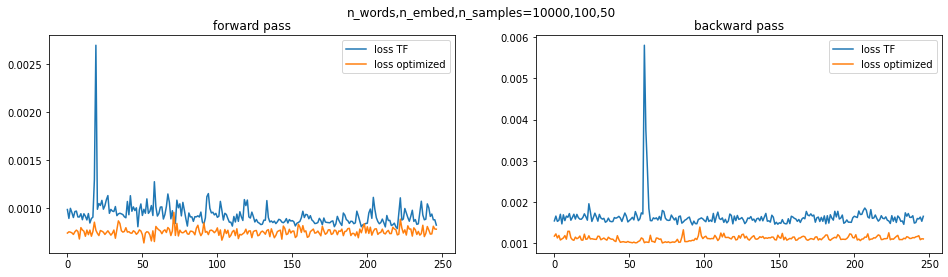

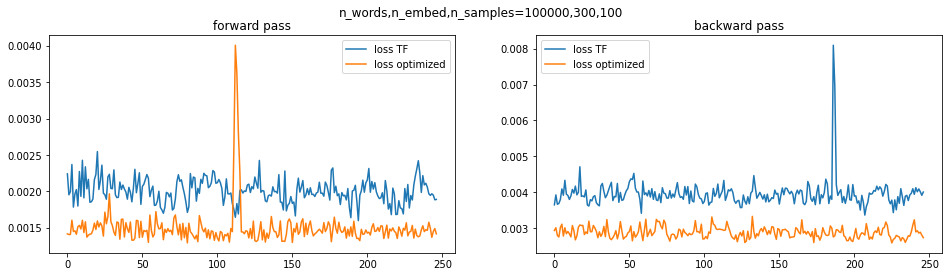

In [23]:
import time
from matplotlib import pyplot as plt

N_BATCH = 256
N_LOOPS = 250
train_data = np.random.randint(0,10,[N_LOOPS,2,N_BATCH],np.int64)

def get_timings(op,train_data,init_op):
  ''' does timings for a graph op several times '''
  with tf.Session() as sess:
    sess.run(init_op)
    times = []
    for inputs_batch,labels_batch in train_data:
      feed_dict = {inputs:inputs_batch,labels:labels_batch}
      time_start = time.time()
      sess.run(op,feed_dict)
      time_end = time.time()
      times.append(time_end-time_start)
  return np.array(times)


for N_WORDS,N_EMBED,N_SAMPLED in [[10000,100,50],[100000,300,100]]:

  ## build task
  tf.reset_default_graph()
  inputs,labels,loss,loss_tf,grads,grads_auto,grads_tf = build_learn_task(N_WORDS,N_EMBED,N_SAMPLED)
  init_op = tf.global_variables_initializer()
  
  ## prepare plots
  _,axs=plt.subplots(1,2,figsize=(16,4))

  ## evaluate forwad pass

  for op,label in zip([loss_tf,loss],['loss TF','loss optimized']):
    timings = get_timings(op,train_data,init_op)  
    axs[0].plot(timings[3:],label=label)
  axs[0].legend()
  axs[0].set_title('forward pass')

  ## evaluate backward pass

  for op,label in zip([grads_tf,grads],['loss TF','loss optimized']):
    timings = get_timings(op,train_data,init_op)  
    axs[1].plot(timings[3:],label=label)
  axs[1].legend()
  axs[1].set_title('backward pass')

  plt.suptitle('n_words,n_embed,n_samples=%s,%s,%s'%(N_WORDS,N_EMBED,N_SAMPLED))
  plt.show()